<a href="https://colab.research.google.com/github/kgudalewski/trading/blob/main/trading_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TODO
# sprawdzić czy wykonywanie strategi działa lokalnie

#offtop
# poszukać źródeł danych które by zawierały minutowe timeframey

In [56]:
real_trade = False

# Set up

In [144]:
# set up
if real_trade:
  import MetaTrader5 as mt5
  from datetime import datetime
  import time
  import pandas as pd
elif not real_trade:
  from datetime import datetime, timedelta
  import time
  import pandas as pd
  from google.colab import drive
  drive.mount('/content/drive')
  import matplotlib.pyplot as plt
  from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [145]:
# MT5 connection init function
if real_trade:
  def initialize_mt5(login, password, server):

      if not mt5.initialize(login=login, password=password, server=server):
          print(f"Nie można połączyć się z MetaTrader 5, błąd: {mt5.last_error()}")
          return False
      print("Połączono z MetaTrader 5")

  # if doesn't work
  # mt5.initialize()
  # mt5.login(login, password, server)

In [146]:
# order send func

if real_trade:

  def create_order(order_type, idx=None, ticker=None, qty=None, sl_pct=None , tp_pct=None):

    if order_type == "BUY":
      order_type = mt5.ORDER_TYPE_BUY
      price = mt5.symbol_info_tick(ticker).ask
      sl = price * (1  - sl_pct)
      tp = price * (1 + tp_pct)
    elif order_type == "SELL":
      order_type = mt5.ORDER_TYPE_SELL
      price = mt5.symbol_info_tick(ticker).bid
      sl = price * (1  + sl_pct)
      tp = price * (1 - tp_pct)

    request = {
      "action": mt5.TRADE_ACTION_DEAL,
      "symbol": ticker,
      "volume": qty,
      "type": order_type,
      "price": price,
      "sl": sl, # FLOAT
      "tp": tp, # FLOAT,
      "comment": "Python open position",
      "type_time": mt5.ORDER_TIME_GTC,
      "type_filling": mt5.ORDER_FILLING_IOC,
    }

    order = mt5.order_send(request)
    return order

elif not real_trade:

  def create_order(order_type, idx):
    if order_type == "BUY": # to znaczy otwarcie longa
      source_df.loc[idx,"open_long"] = 1 # w ostatnim wierszu , kolumnie open_long sygnalizuje otwarcie longa "1"ką
    if order_type == "SELL": # to znaczy otwarcie shorta
      source_df.loc[idx,"open_short"] = 1 # w ostatnim wierszu , kolumnie open_short sygnalizuje otwarcie shorta "1"ką

In [147]:
#order close func

if real_trade:

  def close_order(order_type, idx=None, ticker=None, qty=None):

    if order_type == "BUY":
      order_type = mt5.ORDER_TYPE_BUY
      price = mt5.symbol_info_tick(ticker).ask
    elif order_type == "SELL":
      order_type = mt5.ORDER_TYPE_SELL
      price = mt5.symbol_info_tick(ticker).bid

    request = {
      "action": mt5.TRADE_ACTION_DEAL,
      "symbol": ticker,
      "volume": qty,
      "type": order_type,
      "position": mt5.positions_get()[0]._asdict()['ticket'],
      "price": price,
      "comment": "Close position",
      "type_time": mt5.ORDER_TIME_GTC,
      "type_filling": mt5.ORDER_FILLING_IOC,
    }
    order = mt5.order_send(request)
    return order

elif not real_trade:

  def close_order(order_type, idx):
    if order_type == "BUY": # zamkniecie shorta poprzez wykupienie go
      source_df.loc[idx,"close_short"] = 1 # w ostatnim wierszu , kolumnie close_short sygnalizuje zamkniecie shorta "1"ką (poprzez wykupienie go)
    if order_type == "SELL": # zamkniecie longa poprzez sprzedanie go
      source_df.loc[idx,"close_long"] = 1 # w ostatnim wierszu , kolumnie close_long sygnalizuje zamkniecie longa "1"ką (poprzez sprzedanie go)

In [148]:
# preparing df for imitation

if not real_trade:

  def prepare_for_imitation(df):

    df["open_short"] = 0
    df["close_short"] = 0
    df["open_long"] = 0
    df["close_long"] = 0
    return df

# Introduction to strategy

In [149]:
if real_trade:
  login = 1520661470
  password = "@6$Ejp!k"
  server = "FTMO-Demo2"

  initialize_mt5(login, password, server)

In [150]:
# basic info

ticker = "EURUSD"
sl_pct = .05
tp_pct = .1
qty = 1.0
# interval = mt5.TIMEFRAME_D1
# from_date = datetime.now()
# no_of_rows = 100
# rates = mt5.copy_rates_from(ticker, interval, from_date, no_of_rows)
# account_info = mt5.account_info()
# account_info.balance
# account_info.login
# num_symbols = mt5.symbols_total()
# symbol_info = mt5.symbols_get()
# mt5.symbol_info(ticker)._asdict()

In [151]:
if not real_trade:
  source_df = prepare_for_imitation(pd.read_csv("/content/drive/MyDrive/TSLA_M30_01_2021-11_2024.csv", index_col=0))
  display(source_df.iloc[:10])

,time,open,high,low,close,tick_volume,spread,real_volume,open_short,close_short,open_long,close_long
0,2021-01-04 16:30:00,239.25,247.86,239.01,246.70,14664,0,0,0,0,0,0
1,2021-01-04 17:30:00,246.71,248.08,242.74,245.19,10881,0,0,0,0,0,0
2,2021-01-04 18:30:00,245.23,245.24,239.33,241.20,9201,0,0,0,0,0,0
3,2021-01-04 19:30:00,241.19,243.93,239.98,243.71,7778,0,0,0,0,0,0
4,2021-01-04 20:30:00,243.71,245.46,242.05,242.38,7222,0,0,0,0,0,0
5,2021-01-04 21:30:00,242.37,244.19,241.42,243.61,7443,0,0,0,0,0,0
6,2021-01-04 22:30:00,243.58,244.22,242.68,243.34,4382,0,0,0,0,0,0
7,2021-01-05 16:30:00,241.60,245.10,239.71,244.00,11107,0,0,0,0,0,0
8,2021-01-05 17:30:00,244.01,246.27,243.51,246.08,8439,0,0,0,0,0,0
9,2021-01-05 18:30:00,246.08,246.90,244.46,245.83,6904,0,0,0,0,0,0


# Strategy

In [152]:
if real_trade:
  [(position._asdict()['ticket'],position._asdict()['symbol']) for position in list(mt5.positions_get())]

In [153]:
# needed for strategy execution, depending on real_trade condition
if real_trade:
  iterations = range(600)
elif not real_trade:
  reach = 5
  iterations = range(reach, source_df.shape[0])

In [154]:
# if not real_trade, this conditions need to be predeclared
if not real_trade:
  already_buy = False
  already_sell = False
  no_position = True

# loop
for i in iterations:

  if real_trade:
    df = pd.DataFrame(mt5.copy_rates_range(ticker, mt5.TIMEFRAME_M1, datetime.now() - timedelta(days=7), datetime.now())) # updates df each iteration
  elif not real_trade:
    df = source_df.iloc[i-5:i].copy() # updates df each iteration
  # df['time'] = pd.to_datetime(df['time'], unit = 's') # nie wiem czy to jest potrzebne tutaj do czegoś

# --------------------------------------------------------------------- #

# getting info
  current_close = df.iloc[-1]["close"] # aktualna cena zamknięcia
  last_close = df.iloc[-2]["close"] # wiersz wcześniej cena zamknięcia
  last_high = df.iloc[-2]["high"] # wiersz wcześniej cena high
  last_low = df.iloc[-2]["low"] # wiersz wcześniej cena low

# strategy with output to the rest of code with signal what to do
  long_condition = current_close > last_high
  short_condition = current_close < last_low
  closelong_condition = current_close < last_close
  closeshort_condition = current_close > last_close

# --------------------------------------------------------------------- #

  # downloading data about current positions from mt5, if real_trade condition met
  if real_trade:
    already_buy = False
    already_sell = False
    try:
      already_sell = mt5.positions_get()[0]._asdict['type'] == 1
      already_buy = mt5.positions_get()[0]._asdict['type'] == 0
    except:
      pass

    no_position = len(mt5.positions_get()) == 0

  if long_condition:
    if no_position:
      if real_trade:
        create_order(ticker=ticker, qty=qty, order_type="BUY", sl_pct = sl_pct , tp_pct = tp_pct)
        print("Buy order placed, due to long_condition")
      elif not real_trade:
        create_order("BUY",i)
        long_buy_price = df.iloc[-1]['close']
        no_position = False
        already_buy = True
        # print("Buy order placed, due to long_condition")
    if already_sell:
      if real_trade:
        close_order(ticker=ticker, qty=qty, order_type="BUY")
        print("Sell position closed, due to long_condition")
        time.sleep(1)
        create_order(ticker=ticker, qty=qty, order_type="BUY", sl_pct = sl_pct , tp_pct = tp_pct)
        print("Buy order placed, due to long_condition")
      elif not real_trade:
        close_order("BUY",i)
        # print("Sell position closed, due to long_condition")
        no_position = True
        already_sell = False
        create_order("BUY", i)
        # print("Buy order placed, due to long_condition")
        long_buy_price = df.iloc[-1]['close']
        no_position = False
        already_buy = True
  if short_condition:
    if no_position:
      if real_trade:
        create_order(ticker=ticker, qty=qty, order_type="SELL",sl_pct = sl_pct , tp_pct = tp_pct)
        print("Sell order placed, due to short_condition")
      elif not real_trade:
        create_order("SELL", i)
        # print("Sell order placed, due to short_condition")
        short_sell_price = df.iloc[-1]['close']
        no_position = False
        already_sell = True
    if already_buy:
      if real_trade:
        close_order(ticker=ticker, qty=qty, order_type="SELL")
        print("Buy position closed, due to short_condition")
        time.sleep(1)
        create_order(ticker=ticker, qty=qty, order_type="SELL",sl_pct = sl_pct , tp_pct = tp_pct)
        print("Sell order placed, due to short_condition")
      elif not real_trade:
        close_order("SELL", i)
        # print("Buy position closed, due to short_condition")
        no_position = True
        already_buy = False
        create_order("SELL", i)
        # print("Sell order placed, due to short_condition")
        short_sell_price = df.iloc[-1]['close']
        no_position = False
        already_sell = True

  if not real_trade:
    if already_buy:
      long_sell_price = df.iloc[-1]['close']
      if long_sell_price/long_buy_price > (1 + tp_pct) or long_sell_price/long_buy_price < (1 - sl_pct) : # take profit and stop loss for buy order
        close_order("SELL", i)
        already_buy = False
        no_position = True

    if already_sell:
      short_buy_price = df.iloc[-1]['close']
      if short_sell_price/short_buy_price > (1 + tp_pct) or short_sell_price/short_buy_price < (1 - sl_pct) : # take profit and stop loss for sell order
        close_order("BUY", i)
        already_sell = False
        no_position = True

  if real_trade:
    try:
      already_sell = mt5.positions_get()[0]._asdict['type'] == 1
      already_buy = mt5.positions_get()[0]._asdict['type'] == 0
    except:
      pass

  if closelong_condition and already_buy:
      if real_trade:
        close_order(ticker=ticker, qty=qty, order_type="SELL")
        print("Only buy position closed")
      elif not real_trade:
        close_order("SELL", i)
        already_buy = False
        no_position = True
  if closeshort_condition and already_sell:
      if real_trade:
        close_order(ticker=ticker, qty=qty, order_type="BUY")
        print("Only sell position closed")
      elif not real_trade:
        close_order("BUY", i)
        already_sell = False
        no_position = True

  if real_trade:
    already_buy = False
    already_sell = False

  if real_trade:
    time.sleep(60)

# Backtesting

In [ ]:
df = source_df.copy()
df["profit"] = 1
total_prcnt = 1

for i in range(3,df.shape[0]):
  if df.iloc[i]["open_short"] == 1:
    sell_p_short = df.iloc[i]["close"]
  if df.iloc[i]["open_long"] == 1:
    buy_p_long = df.iloc[i]["close"]
  if df.iloc[i]["close_short"] == 1:
    buy_p_short = df.iloc[i]["close"]
  if df.iloc[i]["close_long"] == 1:
    sell_p_long = df.iloc[i]["close"]
  if df.iloc[i]["close_short"] == 1:
    profit = ((sell_p_short - buy_p_short)/buy_p_short) * 100
    # print(f"Short position ended with profit {profit} % on index {i}") # print info about profit on short order
    total_prcnt = total_prcnt + (total_prcnt * (profit/100))
    # df['profit'][i] = total_prcnt
  if df.iloc[i]["close_long"] == 1:
    profit = ((sell_p_long - buy_p_long)/buy_p_long) * 100
    # print(f"Long position ended with profit {profit} % on index {i}") # print info about profit on long order
    total_prcnt = total_prcnt + (total_prcnt * (profit/100))
    # df['profit'][i] = total_prcnt
  df['profit'][i] = total_prcnt


In [156]:
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume,open_short,close_short,open_long,close_long,profit
11745,2024-11-29 17:30:00,340.74,341.26,338.90,339.25,5294,3,0,0,0,0,0,1.448038
11746,2024-11-29 18:00:00,339.27,339.96,337.70,339.13,4924,3,0,0,0,0,1,1.441112
11747,2024-11-29 18:30:00,339.12,341.22,338.58,340.56,5045,3,0,0,0,0,0,1.441112
11748,2024-11-29 19:00:00,340.58,340.88,339.25,339.71,4752,4,0,0,0,1,0,1.441112
11749,2024-11-29 19:30:00,339.72,345.22,339.50,345.12,5779,3,0,0,0,0,1,1.464062


In [162]:
df.profit.max()

3.454994084985915

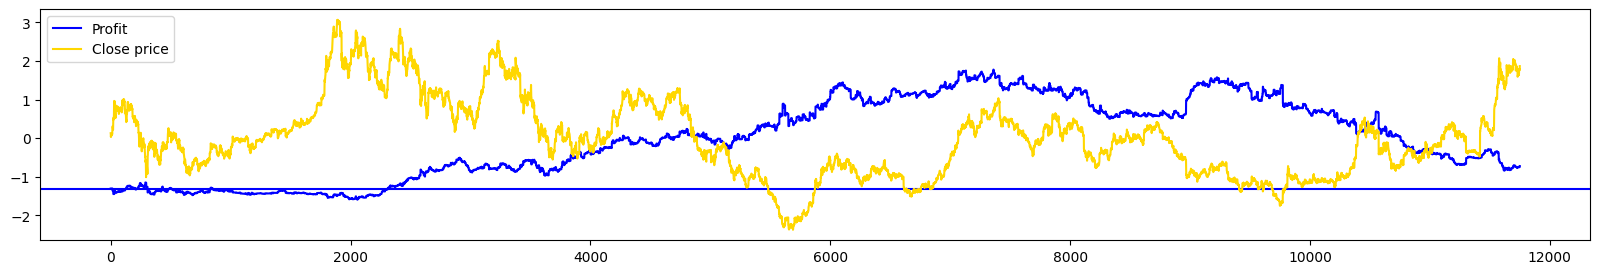

In [157]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(df.index,StandardScaler().fit_transform(pd.DataFrame(df["profit"])), label="Profit", color='blue')
y_line_base_profit = StandardScaler().fit_transform(pd.DataFrame(df["profit"]))[0][0]
plt.axhline(y_line_base_profit,color='blue')
plt.plot(df.index, StandardScaler().fit_transform(pd.DataFrame(df["close"])), label="Close price", color = 'gold')
plt.legend()
plt.show()

In [158]:
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume,open_short,close_short,open_long,close_long,profit
11745,2024-11-29 17:30:00,340.74,341.26,338.90,339.25,5294,3,0,0,0,0,0,1.448038
11746,2024-11-29 18:00:00,339.27,339.96,337.70,339.13,4924,3,0,0,0,0,1,1.441112
11747,2024-11-29 18:30:00,339.12,341.22,338.58,340.56,5045,3,0,0,0,0,0,1.441112
11748,2024-11-29 19:00:00,340.58,340.88,339.25,339.71,4752,4,0,0,0,1,0,1.441112
11749,2024-11-29 19:30:00,339.72,345.22,339.50,345.12,5779,3,0,0,0,0,1,1.464062
